# Neural POS Tagging

## Importing packages and files

In [3]:
import numpy
import torch.nn as nn
import torch.optim

import d

## Loading the training and test corpus

Loading the data:

In [4]:
loaded_data = d.load('de_gsd-ud-train.conllu', 'de_gsd-ud-dev.conllu', 'de_gsd-ud-test.conllu')

Writing dataloaders to variables:

In [5]:
train_dataloader = loaded_data[0]
dev_dataloader = loaded_data[1]
test_dataloader = loaded_data[2]
vocabulary = loaded_data[3]
tagset = loaded_data[4]
pretrained_embeddings = loaded_data[5]

A function that turns a dataloader into a dictionary, where index is the key and tensors with sentences indices and gold tags indices are values. Consequently, the function returns a tuple of two dictionaries: one with sentences, the other with golden tags

In [6]:
def dl_to_dict(dataloader):
    sentences = {}
    golden = {}

    for (i, batch) in enumerate(dataloader):
        sentences[i] = list(batch)[0][0]
        golden[i] = list(batch)[0][1]

    return sentences, golden

Writing dictionaries with sentences and golden tags for dataloaders with training, development and test sets:

In [7]:
train_sentences = dl_to_dict(train_dataloader)[0]
train_gtags = dl_to_dict(train_dataloader)[1]

dev_sentences = dl_to_dict(dev_dataloader)[0]
dev_gtags = dl_to_dict(dev_dataloader)[1]

test_sentences = dl_to_dict(test_dataloader)[0]
test_gtags = dl_to_dict(test_dataloader)[1]

**The original sentence and POS tags for the first instance in the training set:**

In [8]:
print("Sentence: ", vocabulary.lookup_tokens(train_sentences[0].tolist()))
print("Golden tags: ", tagset.lookup_tokens(train_gtags[0].tolist()))

Sentence:  ['sehr', 'gute', 'beratung', ',', 'schnelle', 'behebung', 'der', 'probleme', ',', 'so', 'stelle', 'ich', 'mir', 'kundenservice', 'vor', '</s>']
Golden tags:  ['ADV', 'ADJ', 'NOUN', 'PUNCT', 'ADJ', 'NOUN', 'DET', 'NOUN', 'PUNCT', 'ADV', 'VERB', 'PRON', 'PRON', 'NOUN', 'ADP', 'PUNCT']


## Functions for working with the neural model

### Evaluation function

In [9]:
def evaluation(model, input_dict, target_dict, key):
    #Parameters:
            # - model: LSTM model
            # - input_dict: the dictionary with tensors of sentences
            # - tagset_dict: the dictionary with tensors of golden tags
            # - key: index of a sentence (which is a key in dictionaries)            

    model.eval()
    pos_scores = model(input_dict[key]) # a variable with POS tags scores for each word in a sentence (shape: sentence length x tagset size)
    predicted_indices = list(numpy.argmax(score) for score in pos_scores.tolist())#a list of POS tags with a maximum score for each word
    comparison = list(numpy.array(predicted_indices) == numpy.array(target_dict[key])) # a list of booleans (True if a predicted POS tag corresponds to a golden POS tag)
    accuracy = sum(comparison) / len(predicted_indices) #mean accuracy for the sentence

    return accuracy

### Training function

In [10]:
def training(model, input_dict, target_dict, dev_input_dict, dev_target_dict, epochs_num, optimizer, params):
    #Parameters:
            # - model: LSTM model
            # - input_dict: the dictionary with tensors of sentences
            # - target_dict: the dictionary with tensors of golden tags
            # - dev_input_dict: the dictionary with tensors of sentences in the development set
            # - dev_target_dict: the dictionary with tensors of golden tags in the development set
            # - epochs_num: number of epochs
            # - optimizer: optimizer
            # - params: a dictionary with hyperparameters 

    keys = list(input_dict.keys()) #a variable with keys in the input dictionary    
    
    for epoch in range(epochs_num):  
        #lists for loss and accuracy values. After each epoch contain values for each sentence for the current epoch
        loss_list = []
        accuracy_list = []
        dev_accuracy_list = []

        for i in keys:
            model.zero_grad() #zero previous gradients for the proper backpropagation
            pos_scores = model(input_dict[i]) # a variable with POS tags scores for each word in a sentence (shape: sentence length x tagset size)

            accuracy = evaluation(model, input_dict, target_dict, i) #mean accuracy for the sentence
            accuracy_list.append(accuracy) #add mean accuracy to an accuracy list            

            loss = nn.functional.cross_entropy(pos_scores, target_dict[i])
            loss_list.append(loss) #add loss of the current sentence to the loss list
            loss.backward() #backpropagation

            optimizer.step() #update parameters
        
        for dev_i in list(dev_input_dict.keys()):
            dev_accuracy = evaluation(model, dev_input_dict, dev_target_dict, dev_i) #mean accuracy for the sentence in development set
            dev_accuracy_list.append(dev_accuracy) #add mean accuracy to an accuracy list in development set
            
        mean_loss = sum(loss_list)/len(loss_list) #mean loss for the current epoch: sum of the loss of all sentences divided by the number of sentences        
        
        #print mean loss and mean accuracy for the epoch.
            #mean_loss is a tensor, so .item() gets its value
            #mean accuracy per epoch is a sum of mean accuracies of each sentence divided by the number of sentences (same for the accuracy of the development set)
        print("Epoch " + str(epoch) + " loss: " + str(mean_loss.item()) + '\tmean accuracy: ' + str(sum(accuracy_list) / len(accuracy_list))+'\tmean dev set accuracy: '+ str(sum(dev_accuracy_list) / len(dev_accuracy_list)))


## Defining a neural model

### Embedding layer

Creating an embedding layer of a shape "number of pretrained embeddings" x "dimension of fasttext word embeddings (300)" :

In [11]:
embedding = nn.Embedding(len(pretrained_embeddings), 300)
embedding.weight.data = pretrained_embeddings
embedding.weight.requires_grad = False

### LSTM model class

In [12]:
class LSTM_Model(nn.Module):  
       
    def __init__(self, embedding_dim, hidden_dim, tagset_size, num_layers, bidirect, dropout, embeds):
         #Initialization
        #Parameters:
            # - embedding_dim: the input dimension which corresponds to the dimensionality of the embedding layer
            # - hidden_dim: dimensions of a hidden layer
            # - tagset_size: number of possible tags
            # - num_layers: number of LSTM's stacked onto each other
            # - bidirect: if True - LSTM will be bidirectional and the number of inputs to the linear layer will be doubled
            # - dropout: the percentage of outputs to drop. Used only if the num_layers >= 2 (else equals 0)
            # - embeds: the embedding layer
    
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embeds = embeds
        
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, bidirectional=bidirect, dropout=dropout if num_layers>=2 else 0)
        
        #linear layer input size equals the dimensionality of the hidden layer (or doubled dimensionality if LSTM is bidirectional; the number of outputs equals tagset size)
        self.linear = nn.Linear(in_features=hidden_dim*2 if bidirect else hidden_dim, out_features=tagset_size) 
        self.dropout = nn.Dropout(self.lstm.dropout)

    def forward(self, sentence):
        #sentence is a tensor with sentence indices
        
        embedded = self.dropout(self.embeds(sentence)) #each sentence goes through the embedding matrix and some outputs are dropped if the dropout>0
        lstm_output, _ = self.lstm(embedded.view(len(sentence), 1, -1)) #the embedding of each sentence of a shape "sentence length x 1 (batch size) x embedding dimensions (300) is passed to the LSTM (-1 means that the program calculates the third dimension itself based on first two, but in our case it will always be the dimension of the embedding)
        linear_output = self.linear(self.dropout(lstm_output.view(len(sentence), -1))) #the LSTM output of a sentence (tensor of a shape "sentence length x size of the linear layer input") is passed to the linear layer.

        return linear_output

Defining hyperparameters in a dictionary:

In [13]:
hyper_params = {
    "learning_rate": 0.001,
    "hidden_layer_size": 40,
    "number of epochs": 11,
    "number of layers": 1,
    "bidirectional": True,
    "dropout": 0
}

Creating a model:

In [14]:
lstm_model = LSTM_Model(embedding_dim=embedding.embedding_dim, hidden_dim=hyper_params['hidden_layer_size'], tagset_size=len(tagset), num_layers=hyper_params['number of layers'],bidirect=hyper_params['bidirectional'], dropout=hyper_params['dropout'], embeds=embedding)

Creating an optimizer:

In [15]:
Adam_optimizer = torch.optim.Adam(lstm_model.parameters(), lr = hyper_params['learning_rate'])

## Training a neural model

### Training set with learning curves

In [16]:
#The following line trains the model and prints mean loss, train accuracy and the accuracy of the development set for each epoch:
training(model=lstm_model, input_dict=train_sentences, target_dict=train_gtags, dev_input_dict = dev_sentences, dev_target_dict = dev_gtags, epochs_num=hyper_params['number of epochs'], optimizer=Adam_optimizer, params=hyper_params)

Epoch 0 loss: 0.269575297832489	mean accuracy: 0.9205756567084662	mean dev set accuracy: 0.9090905850517129
Epoch 1 loss: 0.14392763376235962	mean accuracy: 0.9533248300446219	mean dev set accuracy: 0.9125671420822176
Epoch 2 loss: 0.11284291744232178	mean accuracy: 0.9636832603938352	mean dev set accuracy: 0.9148029606259206
Epoch 3 loss: 0.09129871428012848	mean accuracy: 0.9712610985363347	mean dev set accuracy: 0.9136819925929881
Epoch 4 loss: 0.07437170296907425	mean accuracy: 0.9774360004761785	mean dev set accuracy: 0.9135948029562889
Epoch 5 loss: 0.060126446187496185	mean accuracy: 0.9822456262949935	mean dev set accuracy: 0.9128887142281898
Epoch 6 loss: 0.0485248826444149	mean accuracy: 0.9860187797159323	mean dev set accuracy: 0.9113208227950015
Epoch 7 loss: 0.03948327153921127	mean accuracy: 0.9885798182104522	mean dev set accuracy: 0.9110329364095323
Epoch 8 loss: 0.03330867737531662	mean accuracy: 0.990365369920187	mean dev set accuracy: 0.9123179984964583
Epoch 9 loss:

11 training epochs took 57 minutes.

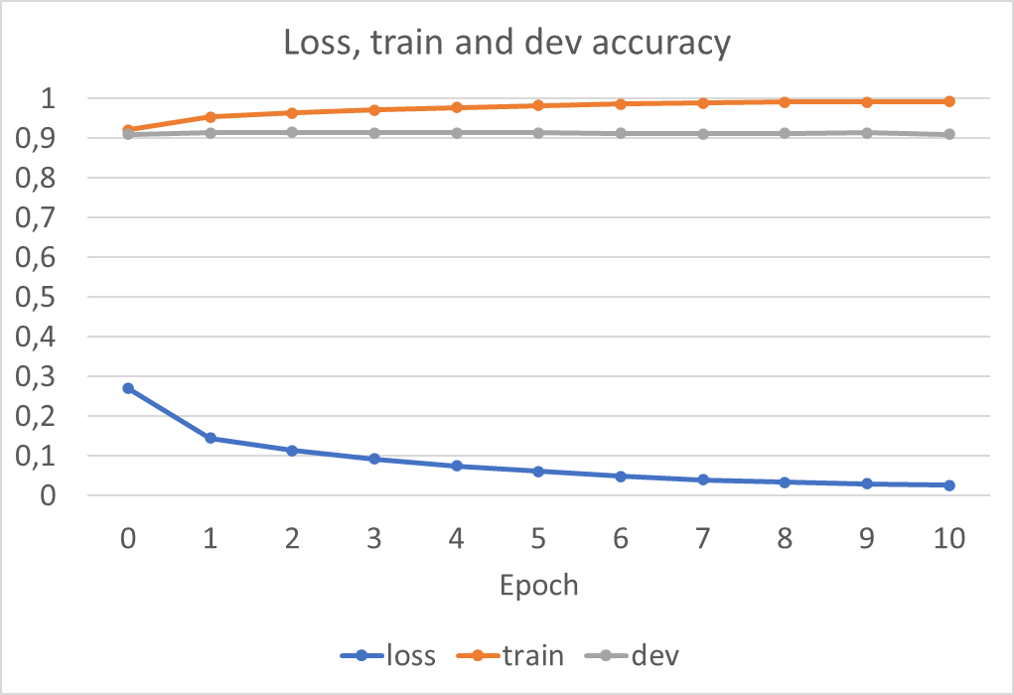

In [19]:
from IPython.display import Image
Image("loss_train_dev.png")

## Test set accuracy evaluation

In [17]:
test_accuracy = []

for idx in list(test_sentences.keys()):
    test_accuracy.append(evaluation(model=lstm_model, input_dict=test_sentences, target_dict=test_gtags, key=idx))
print("Test accuracy: ", sum(test_accuracy)/len(test_accuracy))

Test accuracy:  0.9093816267283222


**I got test accuracy:  0.9093816267283222**

Checking the second sentence in a test set and printing a sentence, its golden tags and predicted tags:

In [20]:
print("Sentence:\n", vocabulary.lookup_tokens(test_sentences[1].tolist()))
print("Golden tags:\n", tagset.lookup_tokens(test_gtags[1].tolist()))

with torch.no_grad():
    prediction = list(numpy.argmax(score) for score in lstm_model(test_sentences[1]))

print("Predicted tags:\n", tagset.lookup_tokens(prediction))

Sentence:
 ['ich', 'habe', 'dort', '2007', 'meinen', 'owd', 'gemacht', 'und', 'weil', 'mir', 'das', 'tauchen', 'so', 'gefiel', 'hab', 'ich', 'dort', 'noch', 'im', 'in', 'dem', 'selben', 'jahr', 'den', 'aowd', 'und', 'den', 'deep', 'drangehängt', '</s>']
Golden tags:
 ['PRON', 'AUX', 'ADV', 'NUM', 'DET', 'PROPN', 'VERB', 'CCONJ', 'SCONJ', 'PRON', 'DET', 'NOUN', 'ADV', 'VERB', 'AUX', 'PRON', 'ADV', 'ADV', '_', 'ADP', 'DET', 'DET', 'NOUN', 'DET', 'PROPN', 'CCONJ', 'DET', 'PROPN', 'VERB', 'PUNCT']
Predicted tags:
 ['PRON', 'AUX', 'ADV', 'NUM', 'DET', 'NOUN', 'VERB', 'CCONJ', 'SCONJ', 'PRON', 'DET', 'NOUN', 'ADV', 'VERB', 'AUX', 'PRON', 'ADV', 'ADV', '_', 'ADP', 'DET', 'DET', 'NOUN', 'DET', 'PROPN', 'CCONJ', 'DET', 'PROPN', 'VERB', 'PUNCT']


There are a couple of errors, but the majority of tags are defined correctly.